### Semi-autonomous Teleoperation Demo : Place task in `Office` scene

### Parse `Realistic Scene`

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


In [2]:
xml_path = '../../../asset/visualize_figure_bookshelf_glass_book.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([-1.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-5,0.80,0])

shelf_pos = np.array([0.8,0.0,0.75])
env.model.body('shelf_row1').pos = shelf_pos
env.model.body('shelf_row1').quat = r2quat(rpy2r(np.radians([0, 0, 90])))
obj_wine_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_wine"))]

# Place objects
n_wine_obj = 2
env.place_objects_random(n_obj=n_wine_obj, obj_names=obj_wine_names, x_range=[0.80, 0.85], y_range=[-0.2, 0.2], z_range=[1.25,1.26], min_dist=0.05, COLORS=False, VERBOSE=True)

# Book1 is target_object
env.model.joint(env.model.body('book6').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.22, 0.02])
env.model.joint(env.model.body('book7').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.16, 0.02])
env.model.joint(env.model.body('book8').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.12, 0.02])
env.model.joint(env.model.body('book9').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.07, 0.02])

env.model.joint(env.model.body('book1').jntadr[0]).qpos0[:3] = np.array([0.2, -0.4, 0.8])
env.model.joint(env.model.body('book1').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.array([1.57, 0, 0])))


window
obj_wine_01: [0.84 0.17 1.25]
obj_wine_02: [ 0.82 -0.15  1.26]


In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0,distance=3.0,elevation=-30,lookat=[0.4,0.0,0.81],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()

# init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
init_ur_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000

i = 0

while env.get_sim_time() <= max_sec:    
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    # env.model.geom_size[env.model.body('obj_box_03').geomadr[0]] += np.array([0.0001,0.0001,0.0001])
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=500):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # + np.array([0,0,-0.2])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

# Close viewer
env.close_viewer()

[-1.01 -0.13  1.16]
Pressed ESC
Quitting.


In [4]:
filtered_pcd = np.load('./data_bookshelf/modified/filtered_pcd.npy')
feasible_pcd = np.load('./data_bookshelf/modified/feasible_pcd_20230914_c48_g4_worker48.npy')

### LLM screening

### Interact with GPT

In [5]:
import os
import openai
import sys
sys.path.append('../../../')
from utils.gpt_helper import set_openai_api_key_from_txt,GPTchatClass,printmd
from utils.wiki_helper import wiki_search
from utils.util import printmd,extract_quoted_words
print ("openai version:[%s]"%(openai.__version__))

openai version:[0.27.8]


In [6]:
import openai
openai.api_key = 'your key' 
model_name = 'gpt-3.5-turbo'#'text-davinci-002' # CaP uses text-davinci-002

class ChatGPT():
    def __init__ (self, system_prompt, model_engine='text-davinci-003'):
        self.model_engine = model_engine
        self.system_prompt = system_prompt
        self.msg_history_davinci = self.system_prompt
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]
        self.role = 'user'
    
    def reset(self):
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]

    def get_answer(self, prompt=None):
        if self.model_engine == 'gpt-3.5-turbo':
            self.msg_history_turbo.append({"role": self.role, "content":prompt})
            response   = openai.ChatCompletion.create(
            model      = self.model_engine,
            temperature= 0.9,
            messages   = self.msg_history_turbo)
            reply_text = response['choices'][0]['message']['content']
            self.msg_history_turbo.append({"role":"assistant", "content":reply_text})

        elif self.model_engine == 'text-davinci-003': 
            self.msg_history_davinci += "You: "+prompt 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = self.msg_history_davinci,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            #stop       = ["You:", "AI:"]
            )
            reply_text = response.choices[0].text.strip().replace('Answer: ', '')
            self.msg_history_davinci+="\n"+"AI: "+reply_text+"\n"

        elif self.model_engine == 'text-davinci-002': 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = prompt,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            )
            reply_text = response['choices'][0]['text'].strip()
        return reply_text



In [7]:
genre_description_list = ["Science Fiction", "Novel", "Textbook", "Fairy Tale", "Romance", "Horror"]
target_object_name = ["Harry Poter", "Game of Throne", "The Lord Of The Rings", "Modern Robotics", "Aritifical Intelligence", "Convex Optimization", "Physics"]
#    "The Hobbit", "The Witcher", "The Chronicles of Narnia"]
# target_object_name = "book1"

user_msg = \
    f"""
    Scene description:
    In the first level of bookshelf: there are some books.
    In the second level of bookshelf: there are some wine glasses.
    
    Task description: 
    The task is to place the {target_object_name[0]} on the table in best fit region.

    This is an example of instruction. For example, answer the output following instructions.

    User: Let me know which region(area) is suitable to place it. Only you can say the region.
        I want to place a 'book'. Say where is the best fit placement region?
        In the first level bookshelf: [books]
        In thw second level bookshelf: [wine glasses]
    GPT-4: [Recommended region: first level bookshelf]

    If you understand, Say "I understand" and I will start the simulation.
    """

In [8]:
llm = ChatGPT(user_msg, model_engine=model_name)
llm.reset()

In [9]:
response_content = llm.get_answer(prompt=user_msg)

In [10]:
printmd(response_content)

I understand. Let's start the simulation.

In [11]:
user_msg = \
    f"""
    Let me know which level of bookshelf is suitable to place it? Only you can say the region.
    I want to place the a 'book' with the genre. Say where is the best fit placement region?
    In the first level bookshelf: [some books]
    In thw second level bookshelf: [some wine glasses]
    """

In [12]:
response_content = llm.get_answer(prompt=user_msg)
printmd(response_content)

Based on the genre of the book, it is best to place it on the first level bookshelf with the other books.

### Test on `the phyiscally plausible place`

In [13]:
def remove_duplicates_with_specific_com(p_com, pointcloud, threshold=0.05):
    filtered_pointcloud = []
    
    for point in pointcloud:
        # Check if the point is close to the specific center of mass (p_com)
        if np.linalg.norm(np.array(point) - np.array(p_com)) < threshold:
            filtered_pointcloud.append(point)
            
    return np.array(filtered_pointcloud)

region_row1 = env.get_p_body('shelf_row1')
row1_pcd = remove_duplicates_with_specific_com(region_row1, filtered_pcd, threshold=0.1)
row1_pcd.shape

(12, 3)

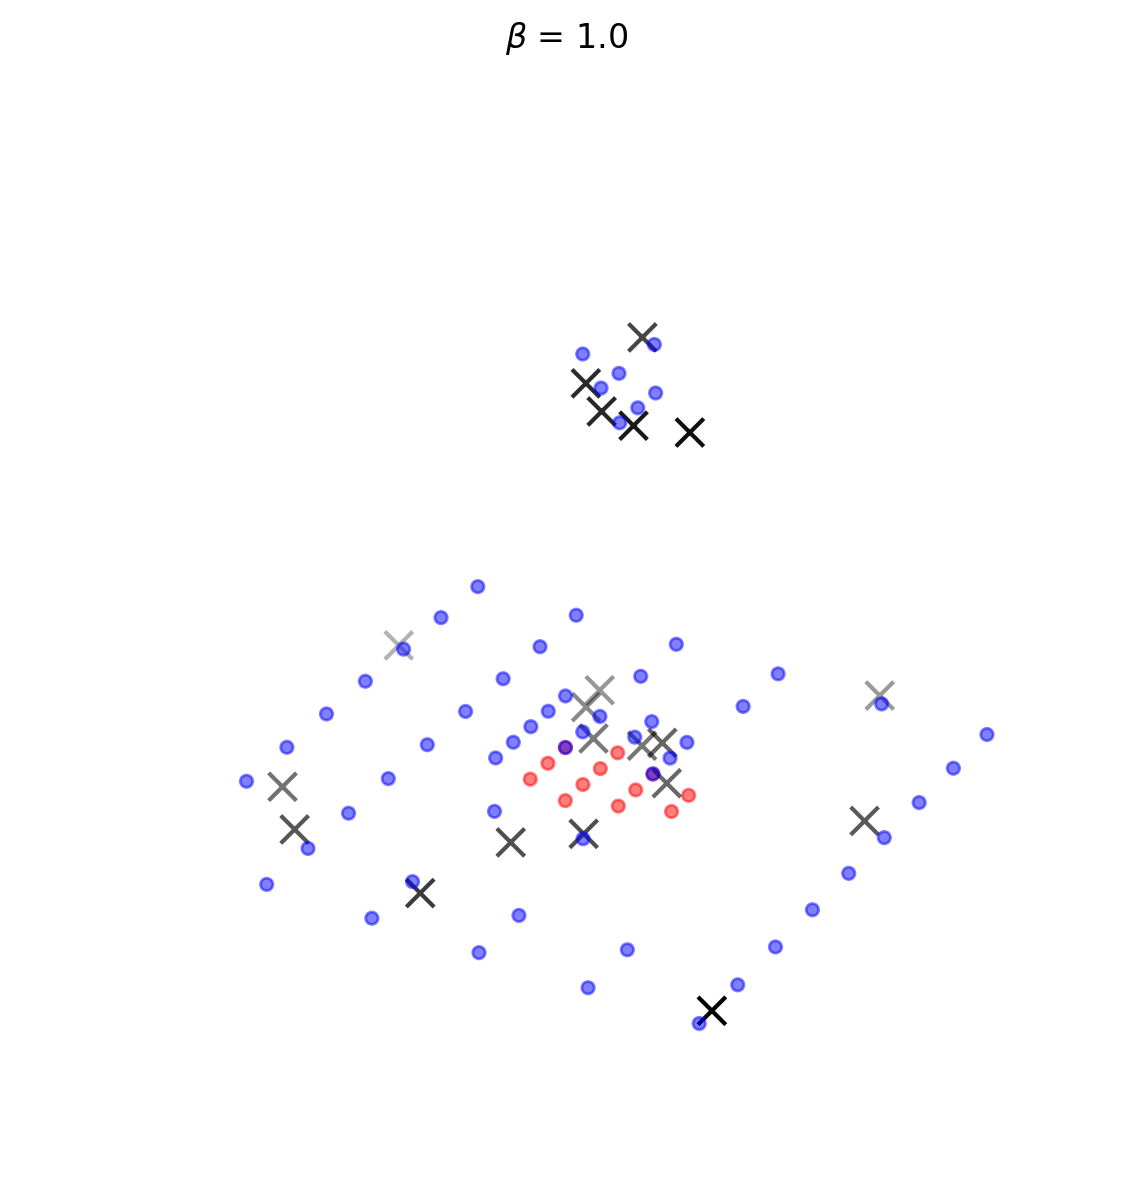

In [16]:
from scipy.stats import gaussian_kde

# Adjust the function to sample from 3D KDE with scaling and debugging
def sample_from_kde_3d_scaled(pcd, kde_values, num_samples=10):
    kde_values_flat = kde_values.flatten()
    kde_sum = np.sum(kde_values_flat)
    
    if np.isclose(kde_sum, 0):
        print(f"Warning: Sum of KDE values is close to zero ({kde_sum})")
        return None

    kde_values_norm = kde_values_flat / kde_sum
    sampled_indices = np.random.choice(len(kde_values_flat), size=num_samples, p=kde_values_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, kde_values.shape)).T
    
    # Scale to the actual range of the data
    x_range = np.linspace(pcd[:, 0].min(), pcd[:, 0].max(), kde_values.shape[0])
    y_range = np.linspace(pcd[:, 1].min(), pcd[:, 1].max(), kde_values.shape[1])
    z_range = np.linspace(pcd[:, 2].min(), pcd[:, 2].max(), kde_values.shape[2])
    
    sampled_xyz = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]], z_range[sampled_coords[:, 2]]]).T
    return sampled_xyz

# Generate some random 3D point clouds as an example
np.random.seed(0)
feasible_pcd = feasible_pcd
red_pcd = row1_pcd

# Beta values for blending
betas = [0.1, 0.5, 1.0]
betas = [1.0]
fig = plt.figure(figsize=(24, 8))

for beta in betas:
    weights1 = np.ones(feasible_pcd.shape[0]) * beta
    weights2 = np.ones(red_pcd.shape[0]) * (1 - beta)
    
    total_weights = np.sum(weights1) + np.sum(weights2)
    weights1 = weights1 / total_weights
    weights2 = weights2 / total_weights
    
    merged_pcd = np.vstack([feasible_pcd, red_pcd])
    merged_weights = np.concatenate([weights1, weights2])

    # KDE computation with adjusted bandwidth
    merged_kde = gaussian_kde(merged_pcd.T, weights=merged_weights, bw_method=0.1)

    # Grid definition with finer resolution
    x_min, x_max = merged_pcd[:, 0].min(), merged_pcd[:, 0].max()
    y_min, y_max = merged_pcd[:, 1].min(), merged_pcd[:, 1].max()
    z_min, z_max = merged_pcd[:, 2].min(), merged_pcd[:, 2].max()
    
    # Increase grid resolution to 50 along each axis
    xi, yi, zi = np.mgrid[x_min:x_max:50j, y_min:y_max:50j, z_min:z_max:50j]
    grid_coords = np.vstack([xi.ravel(), yi.ravel(), zi.ravel()])
    
    # KDE evaluation
    kde_values = merged_kde.evaluate(grid_coords).reshape(xi.shape)
    
    # Sampling with debugging and scaling
    sampled_points = sample_from_kde_3d_scaled(merged_pcd, kde_values, num_samples=20)
    
    # Plotting
    ax = fig.add_subplot(1, 3, betas.index(beta) + 1, projection='3d')
    ax.scatter(feasible_pcd[:, 0], feasible_pcd[:, 1], feasible_pcd[:, 2], c='blue', alpha=0.5)
    ax.scatter(red_pcd[:, 0], red_pcd[:, 1], red_pcd[:, 2], c='red', alpha=0.5)
    
    if sampled_points is not None:
        ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c='black', marker='x', s=100)
    
    ax.set_title(fr'$\beta$ = {beta}')
    ax.axis('off')
plt.show()


### Execute it !!

In [17]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1500
perturb_tick = 500
target_obj_name = 'book1' # 'coke'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

for p in sampled_points:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.01])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
    while env.tick - start < end_tick:
        if not env.is_viewer_alive(): break
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in sampled_points]

        env.render(render_every=5)
        
    if not env.is_viewer_alive(): break    
    env.reset()
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.2
Position: [0.77 0.03 1.06]
max_qw: 0.9999999999986471
min_qw: 0.9999137675589823
Position: [ 0.83 -0.16  0.76]
max_qw: 0.9999960794973638
min_qw: 0.9552836132226604
Position: [0.79 0.01 1.05]
max_qw: 0.9999999743568512
min_qw: 0.9999535219774879
Position: [ 0.77 -0.22  0.76]
max_qw: 0.999998293261358
min_qw: 0.9936002755773065
Position: [0.72 0.18 0.77]
max_qw: 0.9999999999986473
min_qw: 0.9998933771365309
Position: [0.8  0.11 0.77]
max_qw: 0.9999999999986473
min_qw: 0.9998984635943331
Position: [ 0.73 -0.41  0.75]
max_qw: 0.9999999999986474
min_qw: 0.9999090035647705
Position: [0.94 0.51 0.76]
max_qw: 0.9999999999986469
min_qw: 0.9998851256376929
Position: [ 1.05 -0.47  0.75]
max_qw: 0.9999999999986472
min_qw: 0.9999090035647703
Position: [0.71 0.26 0.76]
max_qw: 0.9983778738378477
min_qw: 0.38613509244764443
Position: [0.84 0.07 0.79]
max_qw: 0.9999999999986473
min_qw: 0.9998159366228836
Position: [0.76 0.09 0.77]
max_qw: 0.9999999999986473
min_qw: 0.9998985487085279
Position: [0